In [ ]:
## keyword: ResNet50_64

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-27 10:13:57.110732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745763237.141405   34617 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745763237.150913   34617 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745763237.178138   34617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745763237.178182   34617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745763237.178187   34617 computation_placer.cc:177] computation placer alr

## Resolution: 64x64

### ResNet50_64

In [2]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

In [3]:
# 1. Load dataset
data_64 = np.load("bloodmnist_64.npz")

# 2. Extract images and labels
train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"].flatten()

val_images_64 = data_64["val_images"]
val_labels_64 = data_64["val_labels"].flatten()

test_images_64 = data_64["test_images"]
test_labels_64 = data_64["test_labels"].flatten()

In [4]:
data_64.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [5]:
# 3. One-hot encode labels
train_labels_cat_64 = to_categorical(train_labels_64, num_classes=8)
val_labels_cat_64 = to_categorical(val_labels_64, num_classes=8)
test_labels_cat_64 = to_categorical(test_labels_64, num_classes=8)

In [6]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32 # increase batch size to 32 from 16

train_generator_64 = train_datagen.flow(
    train_images_64, 
    train_labels_cat_64,   
    batch_size=batch_size
)
val_generator_64 = test_datagen.flow(
    val_images_64,
    val_labels_cat_64,
    batch_size=batch_size
)
test_generator_64 = test_datagen.flow(
    test_images_64,
    test_labels_cat_64,
    batch_size=batch_size,
    shuffle=False
)

In [7]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)

# try diffeent drop out rate
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

2025-04-27 10:14:36.552649: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# 6. Compile model 

# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.6506 - auc: 0.8577 - loss: 3.5171 - val_accuracy: 0.1945 - val_auc: 0.5000 - val_loss: 140564.8438
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - accuracy: 0.9219 - auc: 0.9891 - loss: 0.3120 - val_accuracy: 0.2155 - val_auc: 0.5476 - val_loss: 259.6803
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.9518 - auc: 0.9941 - loss: 0.1664 - val_accuracy: 0.8487 - val_auc: 0.9347 - val_loss: 2.4154
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.9623 - auc: 0.9968 - loss: 0.6670 - val_accuracy: 0.9381 - val_auc: 0.9774 - val_loss: 0.3902
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.9640 - auc: 0.9960 - loss: 0.1964 - val_accuracy: 0.9521 - val_auc: 0.9836 - val_loss: 17.3266
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.9677 - auc: 0.9977 - loss: 0.1118 - val_accuracy: 0.9585 - val_auc: 0.9923 - val_loss: 24.2220
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━

In [9]:
model_50_64.save('model_50_64.h5')
model_50_64.save('model_50_64.keras')

# to load:
# from keras.models import load_model
# model_101_64 = load_model('model_101_64.h5')
# from tensorflow.keras.models import load_model
# model_50_64 = load_model('model_50_64.keras', compile=False)

In [11]:
# 8. Evaluate model
test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pixels:      {test_auc_50_64:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9671 - auc: 0.9882 - loss: 0.2421
ResNet50 test accuracy for 64 pixels: 0.9646
ResNet50 test AUC for 64 pixels:      0.9874


In [12]:
# 9. Precision, recall, f1-score
y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step
                      precision    recall  f1-score   support

          neutrophil       0.99      0.99      0.99       244
          eosinophil       1.00      1.00      1.00       624
            basophil       1.00      0.90      0.95       311
          lymphocyte       0.86      0.97      0.91       579
            monocyte       1.00      0.97      0.98       243
immature granulocyte       0.97      0.86      0.91       284
        erythroblast       0.97      0.97      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.96      3421
           macro avg       0.97      0.96      0.96      3421
        weighted avg       0.97      0.96      0.96      3421



In [13]:
# 10. Performance per class
cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9877
eosinophil           accuracy: 0.9968
basophil             accuracy: 0.8971
lymphocyte           accuracy: 0.9741
monocyte             accuracy: 0.9712
immature granulocyte accuracy: 0.8627
erythroblast         accuracy: 0.9655
platelet             accuracy: 1.0000


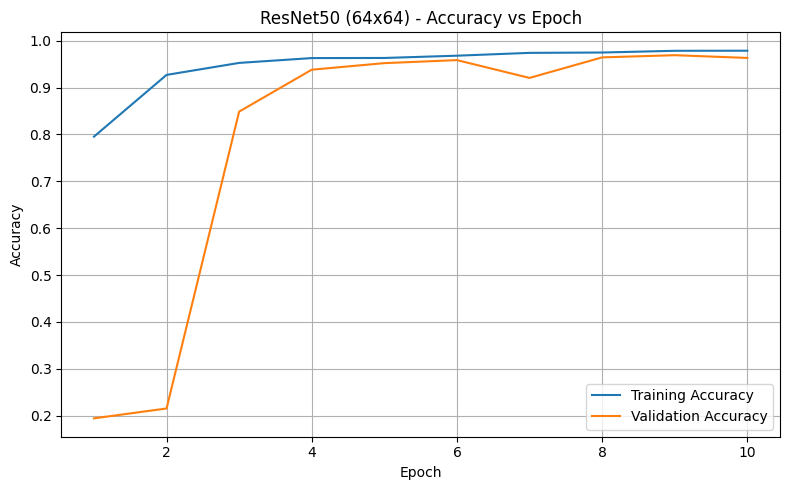

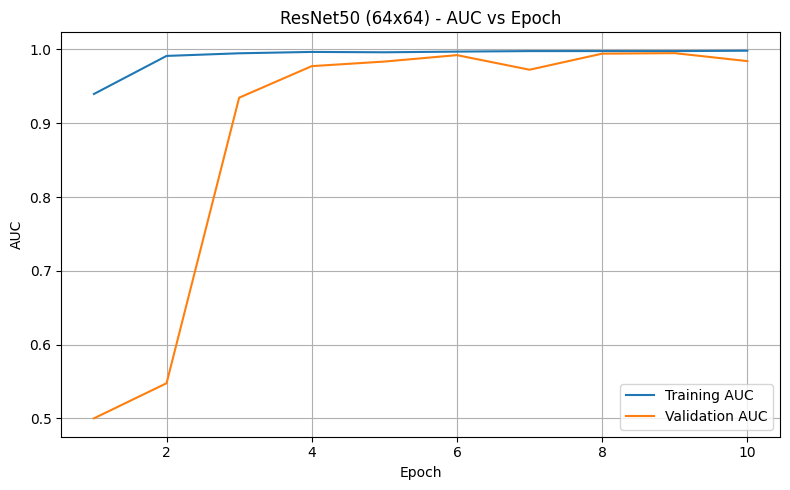

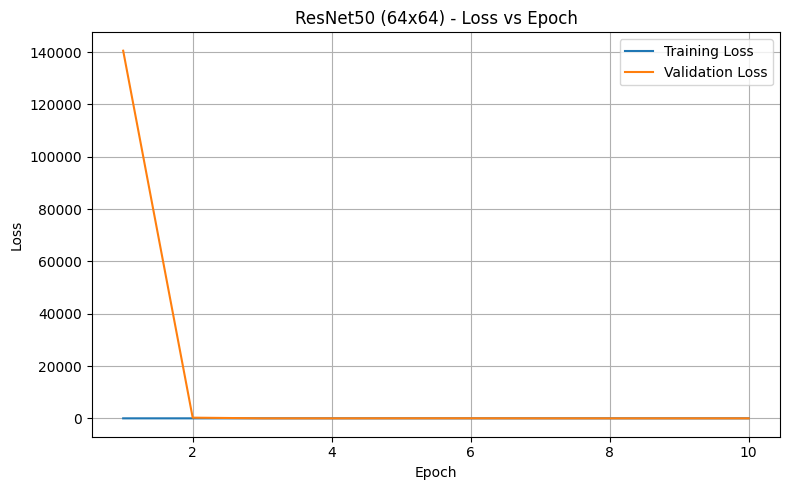

In [14]:
# 11. Plot
epochs = range(1, len(history_50_64.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_64.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (64x64) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_64.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_64.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (64x64) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_64.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_64.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (64x64) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_64.png")
plt.show()

### ResNet101_64

In [7]:
base_101_64 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_101_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_101_64 = Model(inputs=base_101_64.input, outputs=outputs)

2025-04-27 03:03:09.295859: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# 6. Compile model
model_101_64.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
)

In [ ]:
# 7. Train model
print("model_101_64")

history_101_64 = model_101_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
)

model_101_64
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/374 ━━━━━━━━━━━━━━━━━━━━ 13:50 3s/step - accuracy: 0.5002 - auc: 0.7561 - loss: 6.5592

In [11]:
model_101_64.save('model_101_64.h5')
model_101_64.save('model_101_64.keras')

# to load:
# from keras.models import load_model
# model_101_64 = load_model('model_101_64.keras')
# from tensorflow.keras.models import load_model
# model_101_64 = load_model('model_101_64.h5', compile=False)

In [12]:
# 8. Evaluate model
test_loss_101_64, test_acc_101_64, test_auc_101_64 = model_101_64.evaluate(test_generator_64)
print(f"ResNet101 test accuracy for 64 pixels: {test_acc_101_64:.4f}")
print(f"ResNet101 test AUC for 64 pixels:      {test_auc_101_64:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.9554 - auc: 0.9971 - loss: 0.1338
ResNet101 test accuracy for 64 pixels: 0.9591
ResNet101 test AUC for 64 pixels:      0.9975


In [13]:
# 9. Classification report
y_prob_101_64 = model_101_64.predict(test_generator_64)
y_pred_101_64 = np.argmax(y_prob_101_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_101_64, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step
                      precision    recall  f1-score   support

          neutrophil       0.88      1.00      0.94       244
          eosinophil       0.99      1.00      0.99       624
            basophil       0.99      0.95      0.97       311
          lymphocyte       0.91      0.92      0.91       579
            monocyte       0.99      0.89      0.94       243
immature granulocyte       0.92      0.89      0.91       284
        erythroblast       0.97      0.98      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.96      3421
           macro avg       0.96      0.95      0.95      3421
        weighted avg       0.96      0.96      0.96      3421



In [14]:
# 10. Per-class accuracy
cm_101_64 = confusion_matrix(y_true_64, y_pred_101_64)
per_class_acc_101_64 = cm_101_64.diagonal() / cm_101_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9959
eosinophil           accuracy: 0.9952
basophil             accuracy: 0.9518
lymphocyte           accuracy: 0.9171
monocyte             accuracy: 0.8930
immature granulocyte accuracy: 0.8944
erythroblast         accuracy: 0.9775
platelet             accuracy: 0.9957


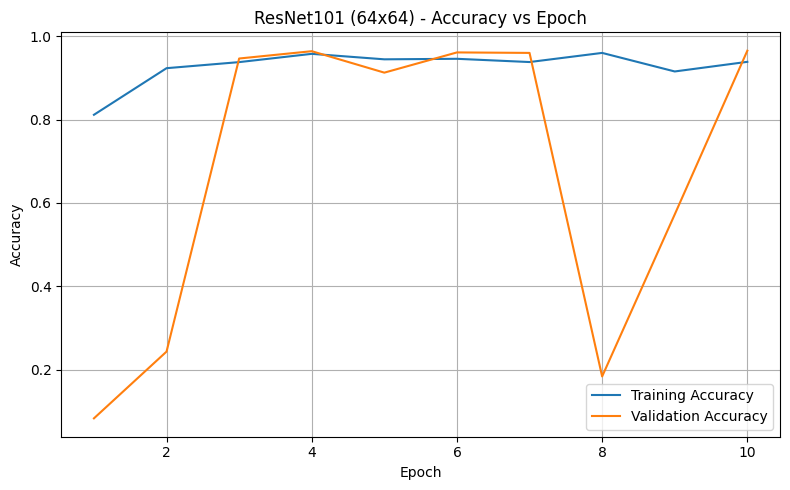

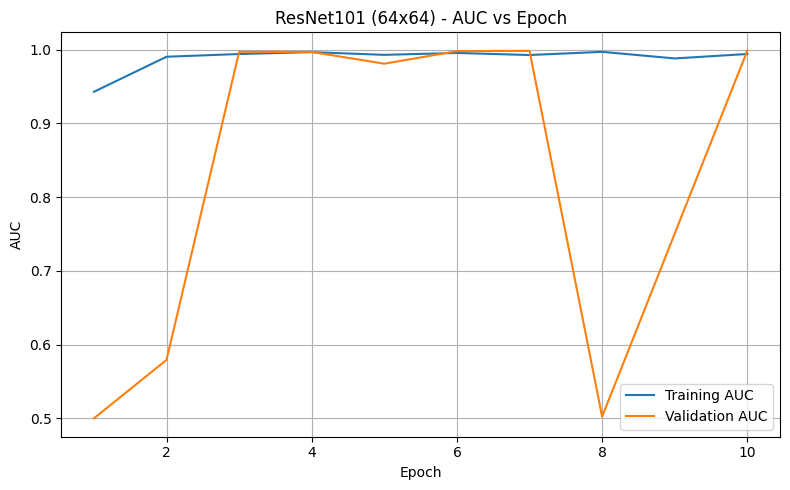

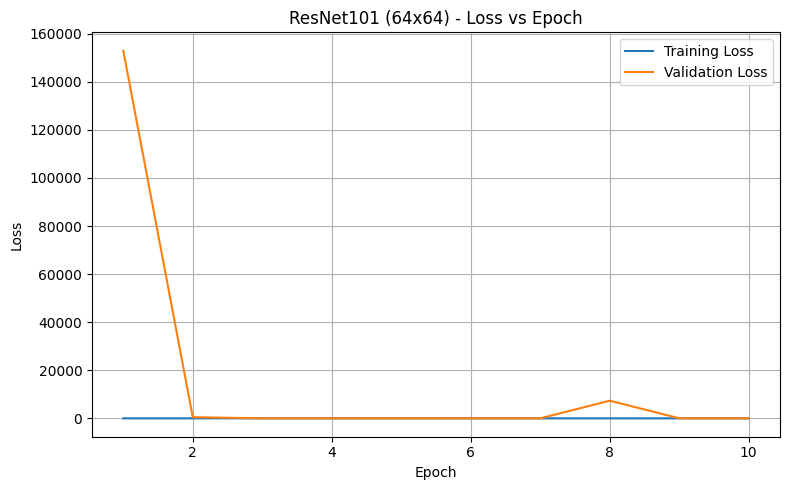

In [15]:
# 11. Plots
epochs = range(1, len(history_101_64.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_64.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_101_64.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 (64x64) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet101_64.png")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_64.history['auc'], label='Training AUC')
plt.plot(epochs, history_101_64.history['val_auc'], label='Validation AUC')
plt.title('ResNet101 (64x64) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet101_64.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_64.history['loss'], label='Training Loss')
plt.plot(epochs, history_101_64.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 (64x64) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet101_64.png")
plt.show()

## Resolution: 128x128

### ResNet50_128

In [16]:
# 1. Load dataset
data_128 = np.load("bloodmnist_128.npz")

# 2. Extract images and labels
train_images_128 = data_128["train_images"]
train_labels_128 = data_128["train_labels"].flatten()

val_images_128 = data_128["val_images"]
val_labels_128 = data_128["val_labels"].flatten()

test_images_128 = data_128["test_images"]
test_labels_128 = data_128["test_labels"].flatten()

In [17]:
# 3. One-hot encode labels
train_labels_cat_128 = to_categorical(train_labels_128, num_classes=8)
val_labels_cat_128 = to_categorical(val_labels_128, num_classes=8)
test_labels_cat_128 = to_categorical(test_labels_128, num_classes=8)

In [18]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator_128 = train_datagen.flow(
    train_images_128, 
    train_labels_cat_128,   
    batch_size=batch_size
)
val_generator_128 = test_datagen.flow(
    val_images_128,
    val_labels_cat_128,
    batch_size=batch_size
)
test_generator_128 = test_datagen.flow(
    test_images_128,
    test_labels_cat_128,
    batch_size=batch_size,
    shuffle=False
)

In [20]:
# 5. Set up ResNet50 
base_50_128 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

x = base_50_128.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_128 = Model(inputs=base_50_128.input, outputs=outputs)

In [21]:
# 6. Compile model
model_50_128.compile(
    optimizer=RMSprop(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

In [22]:
# 7. Train model, capture history for plotting
history_50_128 = model_50_128.fit(
    train_generator_128,
    epochs=10,
    validation_data=val_generator_128
)

Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/374 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.6939 - auc: 0.8663 - loss: 2.8652 

KeyboardInterrupt: 

In [ ]:
# 8. Evaluate model
test_loss_50_128, test_acc_50_128, test_auc_50_128 = model_50_128.evaluate(test_generator_128)
print(f"ResNet50 test accuracy for 128 pixels: {test_acc_50_128:.4f}")
print(f"ResNet50 test AUC for 128 pixels:      {test_auc_50_128:.4f}")

In [ ]:
# 9. Precision, recall, f1-score
y_prob_50_128 = model_50_128.predict(test_generator_128)
y_pred_50_128 = np.argmax(y_prob_50_128, axis=1)
y_true_128 = test_labels_128

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_50_128, target_names=class_names))

In [ ]:
# 10. Performance per class
cm_50_128 = confusion_matrix(y_true_128, y_pred_50_128)
per_class_acc_50_128 = cm_50_128.diagonal() / cm_50_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

In [ ]:
# 11. Plot
epochs = range(1, len(history_50_128.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_128.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (128x128) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_128.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_128.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (128x128) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_128.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_128.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (128x128) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_128.png")
plt.show()

### ResNet101_128

In [ ]:
# 5. Set up ResNet101
base_101_128 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

x = base_101_128.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_101_128 = Model(inputs=base_101_128.input, outputs=outputs)

In [ ]:
# 6. Compile model
model_101_128.compile(
    optimizer=RMSprop(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
)

In [ ]:
# 7. Train model
history_101_128 = model_101_128.fit(
    train_generator_128,
    epochs=10,
    validation_data=val_generator_128
)

In [ ]:
# 8. Evaluate model
test_loss_101_128, test_acc_101_128, test_auc_101_128 = model_101_128.evaluate(test_generator_128)
print(f"ResNet101 test accuracy for 128 pixels: {test_acc_101_128:.4f}")
print(f"ResNet101 test AUC for 128 pixels:      {test_auc_101_128:.4f}")

In [ ]:
# 9. Classification report
y_prob_101_128 = model_101_128.predict(test_generator_128)
y_pred_101_128 = np.argmax(y_prob_101_128, axis=1)
y_true_128 = test_labels_128

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_101_128, target_names=class_names))

In [ ]:
# 10. Per-class accuracy
cm_101_128 = confusion_matrix(y_true_128, y_pred_101_128)
per_class_acc_101_128 = cm_101_128.diagonal() / cm_101_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

In [ ]:
# 11. Plot
epochs = range(1, len(history_101_128.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_128.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_101_128.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 (128x128) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet101_128.png")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_128.history['auc'], label='Training AUC')
plt.plot(epochs, history_101_128.history['val_auc'], label='Validation AUC')
plt.title('ResNet101 (128x128) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet101_128.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_128.history['loss'], label='Training Loss')
plt.plot(epochs, history_101_128.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 (128x128) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet101_128.png")
plt.show()

## Resolution: 224x224

#### ResNet50_224

In [ ]:
# 1. Load dataset
data_224 = np.load("bloodmnist_224.npz")

# 2. Extract images and labels
train_images_224 = data_224["train_images"]
train_labels_224 = data_224["train_labels"].flatten()

val_images_224 = data_224["val_images"]
val_labels_224 = data_224["val_labels"].flatten()

test_images_224 = data_224["test_images"]
test_labels_224 = data_224["test_labels"].flatten()

# 3. One-hot encode labels
train_labels_cat_224 = to_categorical(train_labels_224, num_classes=8)
val_labels_cat_224 = to_categorical(val_labels_224, num_classes=8)
test_labels_cat_224 = to_categorical(test_labels_224, num_classes=8)

In [ ]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32 

train_generator_224 = train_datagen.flow(
    train_images_224, 
    train_labels_cat_224,   
    batch_size=batch_size
)
val_generator_224 = test_datagen.flow(
    val_images_224,
    val_labels_cat_224,
    batch_size=batch_size
)
test_generator_224 = test_datagen.flow(
    test_images_224,
    test_labels_cat_224,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# 5. Set up ResNet50 
base_50_224 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

x = base_50_224.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_224 = Model(inputs=base_50_224.input, outputs=outputs)

In [ ]:
# 6. Compile model
model_50_224.compile(
    optimizer=RMSprop(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_224 = model_50_224.fit(
    train_generator_224,
    epochs=10,
    validation_data=val_generator_224
)

In [ ]:
# 8. Evaluate model
test_loss_50_224, test_acc_50_224, test_auc_50_224 = model_50_224.evaluate(test_generator_224)
print(f"ResNet50 test accuracy for 224 pixels: {test_acc_50_224:.4f}")
print(f"ResNet50 test AUC for 224 pixels:      {test_auc_50_224:.4f}")

In [ ]:
# 9. Precision, recall, f1-score
y_prob_50_224 = model_50_224.predict(test_generator_224)
y_pred_50_224 = np.argmax(y_prob_50_224, axis=1)
y_true_224 = test_labels_224

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_224, y_pred_50_224, target_names=class_names))

In [ ]:
# 10. Performance per class
cm_50_224 = confusion_matrix(y_true_224, y_pred_50_224)
per_class_acc_50_224 = cm_50_224.diagonal() / cm_50_224.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_224):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

In [ ]:
# 11. Plot
epochs = range(1, len(history_50_224.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_224.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_224.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (224x224) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_224.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_224.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_224.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (224x224) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_224.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_224.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_224.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (224x224) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_224.png")
plt.show()

#### ResNet101_224

In [ ]:
# 5. Set up ResNet101
base_101_224 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

x = base_101_224.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(8, activation="softmax")(x)

model_101_224 = Model(inputs=base_101_224.input, outputs=outputs)

In [ ]:
# 6. Compile model
model_101_224.compile(
    optimizer=RMSprop(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
)

# 7. Train model
history_101_224 = model_101_224.fit(
    train_generator_224,
    epochs=10,
    validation_data=val_generator_224
)

In [ ]:
# 8. Evaluate model
test_loss_101_224, test_acc_101_224, test_auc_101_224 = model_101_224.evaluate(test_generator_224)
print(f"ResNet101 test accuracy for 224 pixels: {test_acc_101_224:.4f}")
print(f"ResNet101 test AUC for 224 pixels:      {test_auc_101_224:.4f}")

In [ ]:
# 9. Classification report
y_prob_101_224 = model_101_224.predict(test_generator_224)
y_pred_101_224 = np.argmax(y_prob_101_224, axis=1)
y_true_224 = test_labels_224

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_224, y_pred_101_224, target_names=class_names))

In [ ]:
# 10. Per-class accuracy
cm_101_224 = confusion_matrix(y_true_224, y_pred_101_224)
per_class_acc_101_224 = cm_101_224.diagonal() / cm_101_224.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_224):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

In [ ]:
# 11. Plots
epochs = range(1, len(history_101_224.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_224.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_101_224.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 (224x224) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet101_224.png")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_224.history['auc'], label='Training AUC')
plt.plot(epochs, history_101_224.history['val_auc'], label='Validation AUC')
plt.title('ResNet101 (224x224) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet101_224.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_224.history['loss'], label='Training Loss')
plt.plot(epochs, history_101_224.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 (224x224) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet101_224.png")
plt.show()